In [169]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

(454, 687, 3)


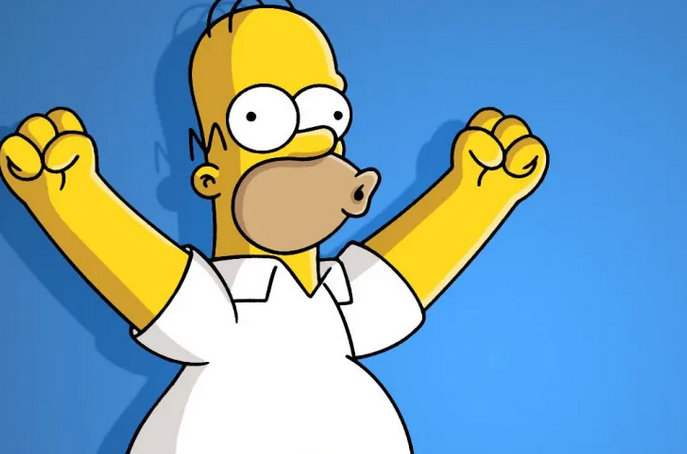

In [147]:
images = ["marilyn-monroe.png", "simpsons.png", "spiderman.jpg"]
index = 1
image = cv2.imread(images[index])
print(image.shape)
cv2_imshow(image)

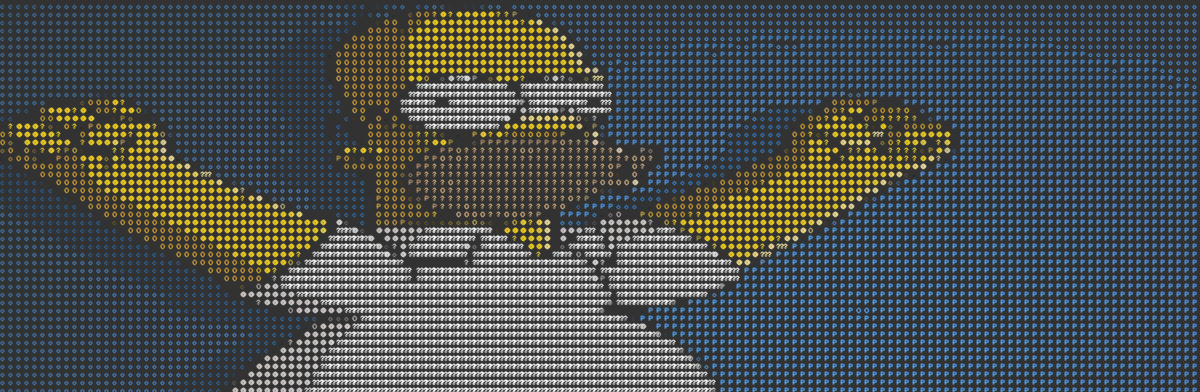

In [149]:
def img2ascii(image_path, output_width=100, save_path=False, original_colors = True):
    """
    Draw ASCII characters based on pixel brightness.
    """
    image = cv2.imread(image_path)

    ASCII_CHARS = "$@B%8&WM#*oahkbdpqwmZO0QLCJUYXzcvunxrjft/\|()1{}[]?-_+~<>i!lI;:,^`'."[::-1]
    ASCII_CHARS = "■@%#*+=-:. "[::-1]
    ASCII_CHARS = "■@?OPoc:. "[::-1] # opencv doesnt put ■

    # Resize the image based on the desired output width
    height, width, _ = image.shape
    aspect_ratio = height / width
    new_height = int(output_width * aspect_ratio * 0.5)
    resized_image = cv2.resize(image, (output_width, new_height))

    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    font_scale = 0.2
    font_thickness = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    character_width = character_height = 8  # estimated width of each ASCII character
    # character_height = int(character_width * aspect_ratio) # estimated height of each ASCII character
    ascii_image_width = character_width * output_width
    ascii_image_height = character_height * new_height
    ascii_image = np.ones((ascii_image_height, ascii_image_width, 3), dtype=np.uint8) * 50

    for y in range(new_height):
        for x in range(output_width):
            pixel_gray = gray_image[y, x]
            ascii_char = ASCII_CHARS[int(pixel_gray / 256 * len(ASCII_CHARS))]

            color = resized_image[y, x] if original_colors else (255,255,255)

            pos_x = x * character_width
            pos_y = y * character_height + character_height

            cv2.putText(
                ascii_image,
                ascii_char,
                (pos_x, pos_y),
                font,
                font_scale,
                (int(color[0]), int(color[1]), int(color[2])),
                font_thickness,
                lineType=cv2.LINE_AA
            )
    cv2_imshow(ascii_image)

    if save_path:
        cv2.imwrite(save_path, ascii_image)
        print(f"ASCII art image saved to {save_path}")

# I want to get edges of the image and use sobel filter to get the gradients of it, and use the gradients to plot edges as ascii_chars of special chars.


img2ascii(images[1],
          output_width=150,
          output_path="ascii_art.jpg",
          save = False,
          original_colors=True)


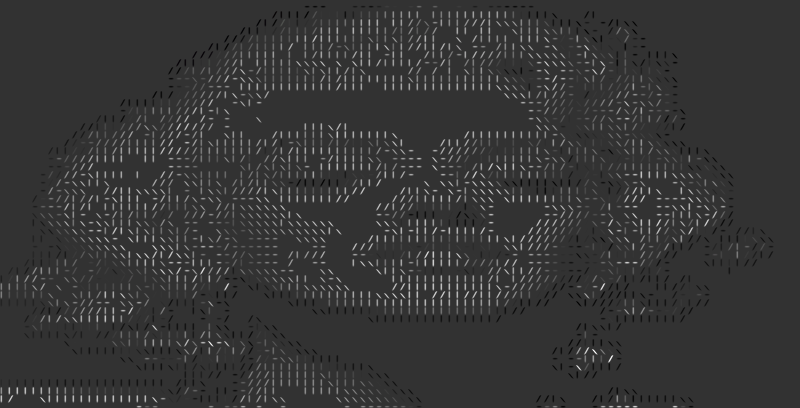

In [162]:
def img2ascii_edges_(image_path, output_width=100, save_path=None, original_colors=True):
    """
    Draws ASCII characters based on edge direction with Sobel filter.
    """
    image = cv2.imread(image_path)

    ASCII_CHARS_FOR_EDGES = {
        'horizontal': '-',
        'vertical': '|',
        'diagonal': '/',
        'anti-diagonal': '\\',
        'no_edge': ' '
    }

    height, width, _ = image.shape
    aspect_ratio = height / width
    new_height = int(output_width * aspect_ratio * 0.5)
    resized_image = cv2.resize(image, (output_width, new_height))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply Sobel filter to get gradients
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) * (180 / np.pi)  # Angle of edges

    font_scale = 0.2
    font_thickness = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    character_width = character_height = 8
    ascii_image_width = character_width * output_width
    ascii_image_height = character_height * new_height
    ascii_image = np.ones((ascii_image_height, ascii_image_width, 3), dtype=np.uint8) * 50

    for y in range(new_height):
        for x in range(output_width):
            mag = magnitude[y, x]
            ang = angle[y, x]

            # Choose character based on direction and magnitude of gradient
            if mag > 50:  # Threshold for edge strength
                if -22.5 <= ang <= 22.5 or ang >= 157.5 or ang <= -157.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['horizontal']
                elif 67.5 <= ang <= 112.5 or -112.5 <= ang <= -67.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['vertical']
                elif 22.5 < ang < 67.5 or -157.5 < ang < -112.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['diagonal']
                else:
                    ascii_char = ASCII_CHARS_FOR_EDGES['anti-diagonal']
            else:
                ascii_char = ASCII_CHARS_FOR_EDGES['no_edge']

            # Set character color based on original image
            color = resized_image[y, x] if original_colors else (255, 255, 255)

            pos_x = x * character_width
            pos_y = y * character_height + character_height

            cv2.putText(
                ascii_image,
                ascii_char,
                (pos_x, pos_y),
                font,
                font_scale,
                (int(color[0]), int(color[1]), int(color[2])),
                font_thickness,
                lineType=cv2.LINE_AA
            )

    cv2_imshow(ascii_image)

    if save_path:
        cv2.imwrite(save_path, ascii_image)
        print(f"ASCII art image saved to {save_path}")

# Usage example:
img2ascii(images[0],
          output_width=100,
          output_path="ascii_art.jpg",
          save = False,
          original_colors=True)


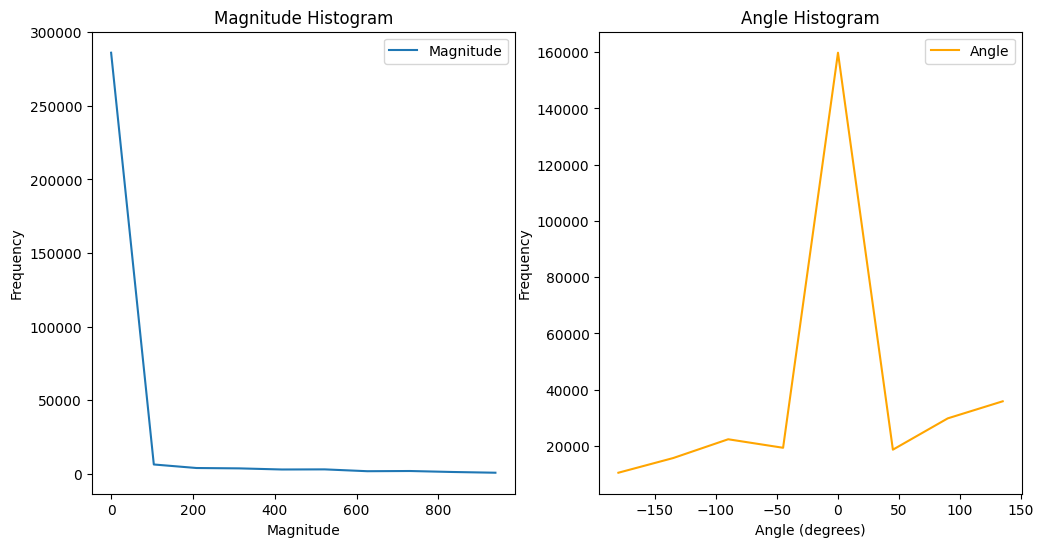

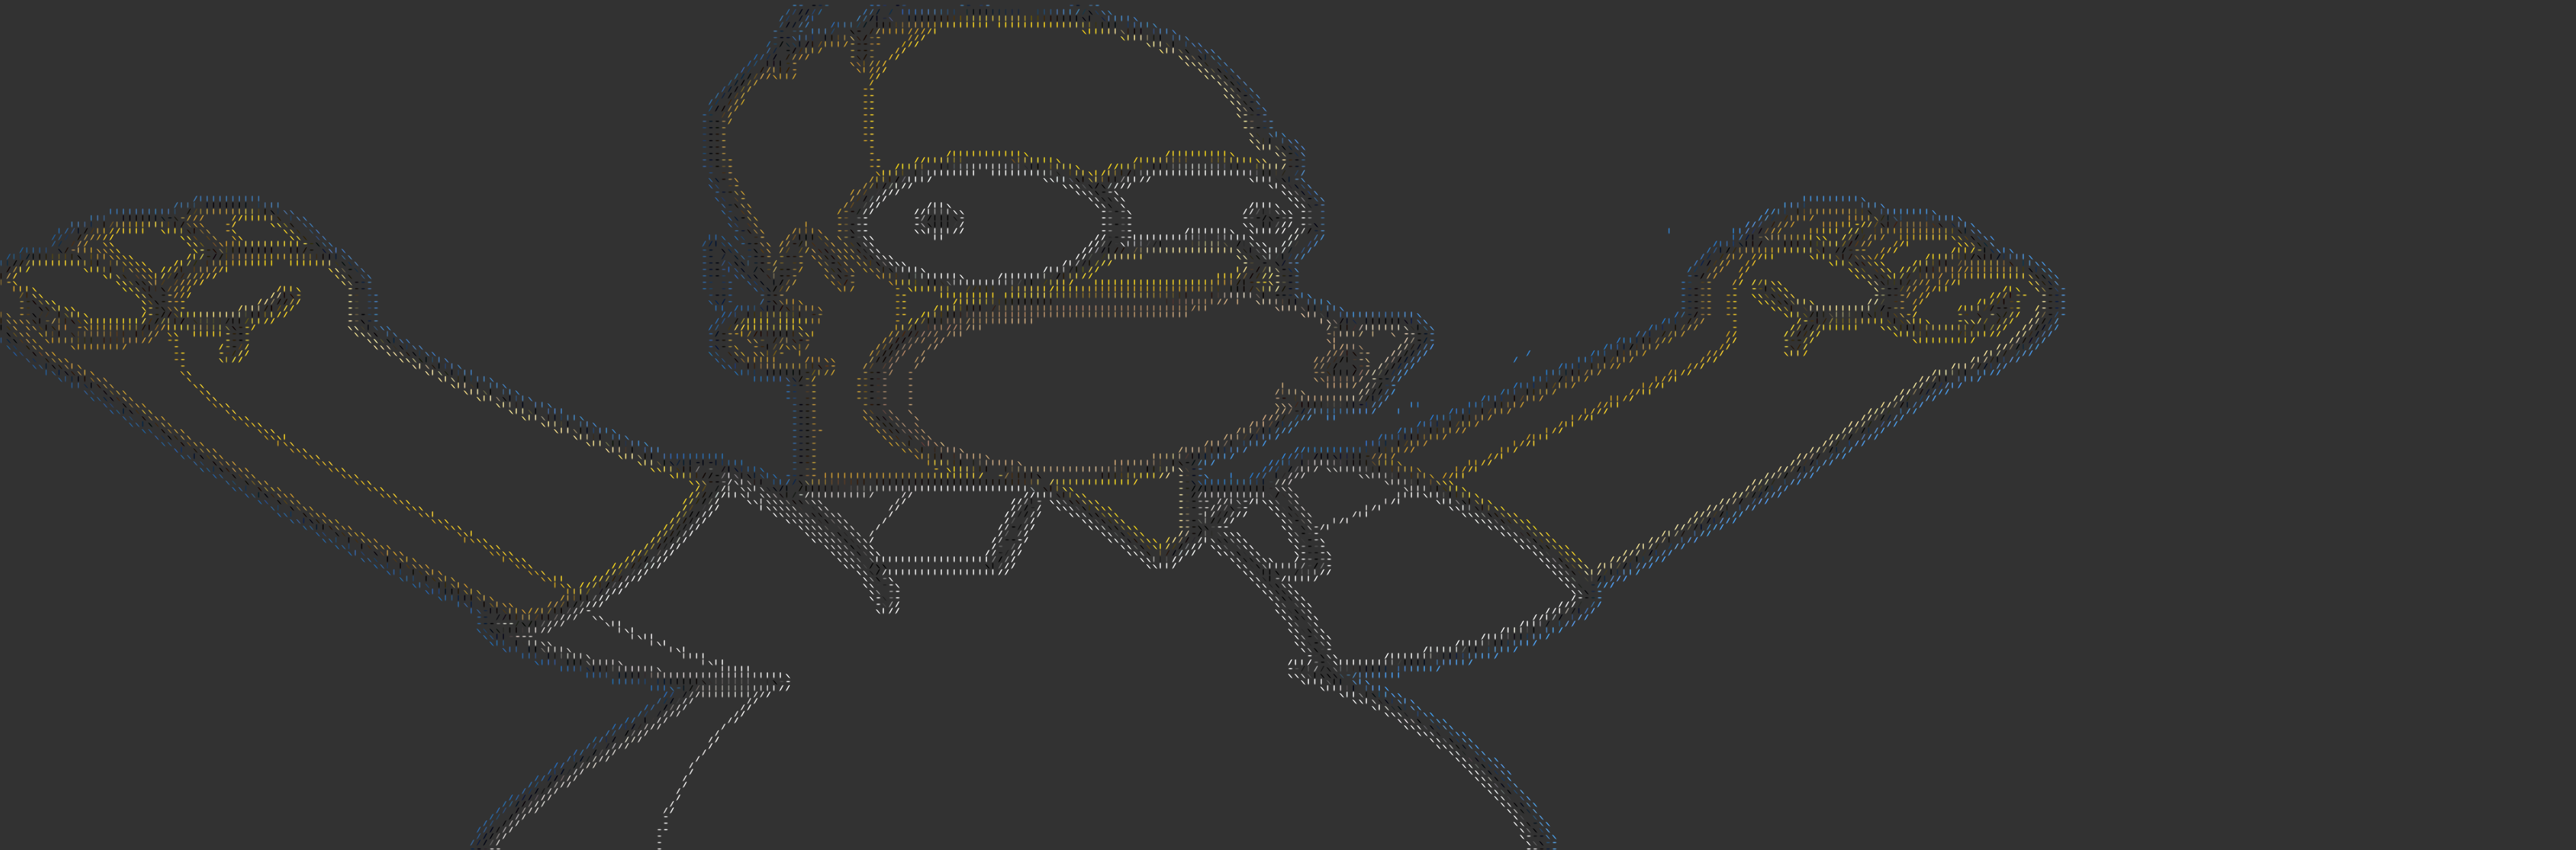

In [181]:

def img2ascii_edges_with_histogram(image_path, output_width=100, save_path=None, original_colors=True):
    """
    Draws ASCII characters based on edge direction with Sobel filter, using histogram from original image.
    """
    # Load the original image
    image = cv2.imread(image_path)

    # ASCII characters mapping based on edge directions
    ASCII_CHARS_FOR_EDGES = {
        'horizontal': '-',
        'vertical': '|',
        'diagonal': '/',
        'anti-diagonal': '\\',
        'no_edge': ' '
    }

    # Calculate Sobel edges for the original image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) * (180 / np.pi)  # Angle in degrees

    # Create histograms for magnitude and angle
    magnitude_hist, magnitude_bins = np.histogram(magnitude, bins=10, range=(0, magnitude.max()))
    angle_hist, angle_bins = np.histogram(angle, bins=8, range=(-180, 180))

    # Display histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(magnitude_bins[:-1], magnitude_hist, label="Magnitude")
    plt.title("Magnitude Histogram")
    plt.xlabel("Magnitude")
    plt.ylabel("Frequency")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(angle_bins[:-1], angle_hist, label="Angle", color="orange")
    plt.title("Angle Histogram")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Resize image to desired output width while maintaining aspect ratio
    height, width = image.shape[:2]
    aspect_ratio = height / width
    new_height = int(output_width * aspect_ratio * 0.5)
    resized_image = cv2.resize(image, (output_width, new_height))
    gray_resized = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Prepare ASCII canvas
    font_scale = 0.2
    font_thickness = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    character_width = character_height = 8
    ascii_image_width = character_width * output_width
    ascii_image_height = character_height * new_height
    ascii_image = np.ones((ascii_image_height, ascii_image_width, 3), dtype=np.uint8) * 50

    # Apply Sobel to resized image and generate ASCII art
    sobelx_resized = cv2.Sobel(gray_resized, cv2.CV_64F, 1, 0, ksize=3)
    sobely_resized = cv2.Sobel(gray_resized, cv2.CV_64F, 0, 1, ksize=3)
    magnitude_resized = np.sqrt(sobelx_resized**2 + sobely_resized**2)
    angle_resized = np.arctan2(sobely_resized, sobelx_resized) * (180 / np.pi)

    for y in range(new_height):
        for x in range(output_width):
            mag = magnitude_resized[y, x]
            ang = angle_resized[y, x]

            # Determine ASCII character based on angle and magnitude using threshold
            if mag > 130:  # Edge threshold
                if -22.5 <= ang <= 22.5 or ang >= 157.5 or ang <= -157.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['horizontal']
                elif 67.5 <= ang <= 112.5 or -112.5 <= ang <= -67.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['vertical']
                elif 22.5 < ang < 67.5 or -157.5 < ang < -112.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['diagonal']
                else:
                    ascii_char = ASCII_CHARS_FOR_EDGES['anti-diagonal']
            else:
                ascii_char = ASCII_CHARS_FOR_EDGES['no_edge']

            # Set character color based on original image
            color = resized_image[y, x] if original_colors else (255, 255, 255)

            pos_x = x * character_width
            pos_y = y * character_height + character_height

            cv2.putText(
                ascii_image,
                ascii_char,
                (pos_x, pos_y),
                font,
                font_scale,
                (int(color[0]), int(color[1]), int(color[2])),
                font_thickness,
                lineType=cv2.LINE_AA
            )

    # Display or save ASCII image
    cv2_imshow(ascii_image)
    if save_path:
        cv2.imwrite(save_path, ascii_image)
        print(f"ASCII art image saved to {save_path}")

# Usage example:

def img2ascii_edges_with_shading(image_path, output_width=100, save_path = None, original_colors=True):
    """
    Draws ASCII characters based on edge direction and applies shading for non-edge areas.
    """
    image = cv2.imread(image_path)

    ASCII_CHARS_FOR_EDGES = {
        'horizontal': '-',
        'vertical': '|',
        'diagonal': '/',
        'anti-diagonal': '\\',
        'no_edge': ' '
    }
    ASCII_CHARS = "■@?OPoc:. "[::-1]

    # Calculate Sobel edges for the original image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) * (180 / np.pi)  # Angle in degrees

    # Resize image to desired output width while maintaining aspect ratio
    height, width = image.shape[:2]
    aspect_ratio = height / width
    new_height = int(output_width * aspect_ratio * 0.5)
    resized_image = cv2.resize(image, (output_width, new_height))
    gray_resized = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Prepare ASCII canvas
    font_scale = 0.2
    font_thickness = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    character_width = character_height = 8
    ascii_image_width = character_width * output_width
    ascii_image_height = character_height * new_height
    ascii_image = np.ones((ascii_image_height, ascii_image_width, 3), dtype=np.uint8) * 50

    # Apply Sobel to resized image and generate ASCII art
    sobelx_resized = cv2.Sobel(gray_resized, cv2.CV_64F, 1, 0, ksize=3)
    sobely_resized = cv2.Sobel(gray_resized, cv2.CV_64F, 0, 1, ksize=3)
    magnitude_resized = np.sqrt(sobelx_resized**2 + sobely_resized**2)
    angle_resized = np.arctan2(sobely_resized, sobelx_resized) * (180 / np.pi)

    for y in range(new_height):
        for x in range(output_width):
            mag = magnitude_resized[y, x]
            ang = angle_resized[y, x]

            # Determine ASCII character based on edge magnitude and angle
            if mag > 130:  # Threshold for edge strength
                if -22.5 <= ang <= 22.5 or ang >= 157.5 or ang <= -157.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['horizontal']
                elif 67.5 <= ang <= 112.5 or -112.5 <= ang <= -67.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['vertical']
                elif 22.5 < ang < 67.5 or -157.5 < ang < -112.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['diagonal']
                else:
                    ascii_char = ASCII_CHARS_FOR_EDGES['anti-diagonal']
            else:
                # For non-edges, map the grayscale intensity to ASCII characters
                intensity = gray_resized[y, x]
                ascii_index = int(intensity / 255 * (len(ASCII_CHARS) - 1))
                ascii_char = ASCII_CHARS[ascii_index]

            # Set character color based on original image
            color = resized_image[y, x] if original_colors else (255, 255, 255)

            pos_x = x * character_width
            pos_y = y * character_height + character_height

            cv2.putText(
                ascii_image,
                ascii_char,
                (pos_x, pos_y),
                font,
                font_scale,
                (int(color[0]), int(color[1]), int(color[2])),
                font_thickness,
                lineType=cv2.LINE_AA
            )

    cv2_imshow(ascii_image)
    if save_path:
        cv2.imwrite(save_path, ascii_image)
        print(f"ASCII art image saved to {save_path}")

# Usage example:
img2ascii_edges_with_shading(images[1],
          output_width=400,
          save = "ascii_art.jpg",
          original_colors=False)

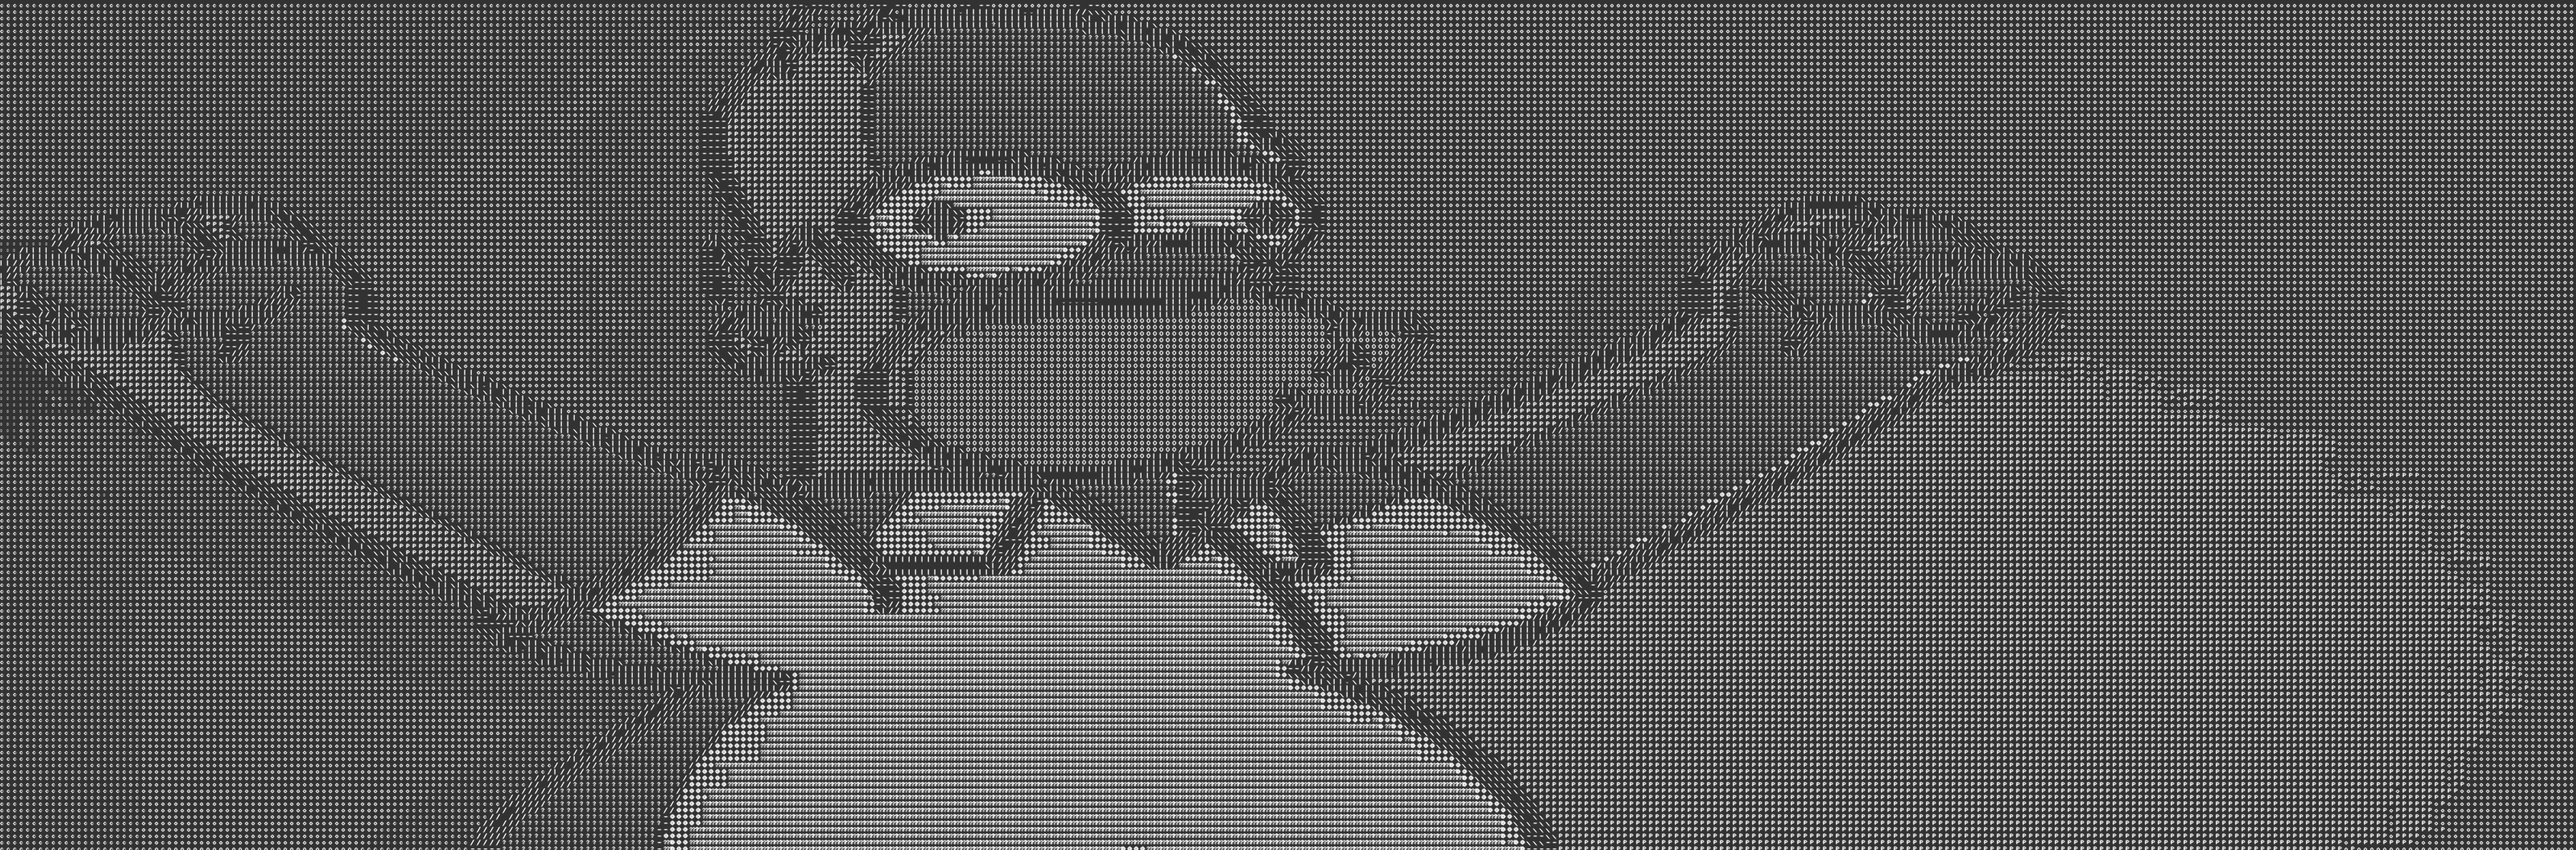

In [185]:

def img2ascii_edges_with_shading(image_path, output_width=100, save_path=None, original_colors=True):
    """
    Draws ASCII characters based on edge direction and applies shading for non-edge areas.
    """
    image = cv2.imread(image_path)

    ASCII_CHARS_FOR_EDGES = {
        'horizontal': '-',
        'vertical': '|',
        'diagonal': '/',
        'anti-diagonal': '\\',
        'no_edge': ' '
    }
    ASCII_CHARS = "■@?OPoc:. "[::-1]

    # Calculate Sobel edges for the original image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) * (180 / np.pi)  # Angle in degrees

    # Resize image to desired output width while maintaining aspect ratio
    height, width = image.shape[:2]
    aspect_ratio = height / width
    new_height = int(output_width * aspect_ratio * 0.5)
    resized_image = cv2.resize(image, (output_width, new_height))
    gray_resized = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Prepare ASCII canvas
    font_scale = 0.2
    font_thickness = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    character_width = character_height = 8
    ascii_image_width = character_width * output_width
    ascii_image_height = character_height * new_height
    ascii_image = np.ones((ascii_image_height, ascii_image_width, 3), dtype=np.uint8) * 50

    # Apply Sobel to resized image and generate ASCII art
    sobelx_resized = cv2.Sobel(gray_resized, cv2.CV_64F, 1, 0, ksize=3)
    sobely_resized = cv2.Sobel(gray_resized, cv2.CV_64F, 0, 1, ksize=3)
    magnitude_resized = np.sqrt(sobelx_resized**2 + sobely_resized**2)
    angle_resized = np.arctan2(sobely_resized, sobelx_resized) * (180 / np.pi)

    for y in range(new_height):
        for x in range(output_width):
            mag = magnitude_resized[y, x]
            ang = angle_resized[y, x]

            # Determine ASCII character based on edge magnitude and angle
            if mag > 130:  # Threshold for edge strength
                if -22.5 <= ang <= 22.5 or ang >= 157.5 or ang <= -157.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['horizontal']
                elif 67.5 <= ang <= 112.5 or -112.5 <= ang <= -67.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['vertical']
                elif 22.5 < ang < 67.5 or -157.5 < ang < -112.5:
                    ascii_char = ASCII_CHARS_FOR_EDGES['diagonal']
                else:
                    ascii_char = ASCII_CHARS_FOR_EDGES['anti-diagonal']
            else:
                # For non-edges, map the grayscale intensity to ASCII characters
                intensity = gray_resized[y, x]
                ascii_index = int(intensity / 255 * (len(ASCII_CHARS) - 1))
                ascii_char = ASCII_CHARS[ascii_index]

            # Set character color based on original image
            color = resized_image[y, x] if original_colors else (255, 255, 255)

            pos_x = x * character_width
            pos_y = y * character_height + character_height

            cv2.putText(
                ascii_image,
                ascii_char,
                (pos_x, pos_y),
                font,
                font_scale,
                (int(color[0]), int(color[1]), int(color[2])),
                font_thickness,
                lineType=cv2.LINE_AA
            )

    cv2_imshow(ascii_image)
    if save_path:
        cv2.imwrite(save_path, ascii_image)
        print(f"ASCII art image saved to {save_path}")

# Usage example:
img2ascii_edges_with_shading(images[1],
          output_width=400,
          save = "ascii_art.jpg",
          original_colors=False)